# Interactive Fantasy Football Tool
Robert Lusardi and Brad Litt\
November 2023

### Summary
See below for a general narrative regarding scraping and cleaning the data so Brad can integrate it into his interactive user interface!\
This code was specific to 2022, but I tried to generalize it for other years in a separate script (see Github folder)

In [1]:
import pandas as pd
import numpy as np

### Step 1: Reading in and Analyzing Data
- Need to scrape data from pro football reference, a comprehensive football stats website
- Determine layout of data, columns, etc.

In [2]:
#code to scrape data from pro football reference, a comprehensive football statisitcs website
#stats for all seasons have the same url, only thing that changes is the year
left_url = "https://www.pro-football-reference.com/years/"
right_url = "/fantasy.htm"

#container of dataframes
test = []
#read in past 6 years of fantasy football data (incl. curr season) using pandas read_html function and for loop
#read_html returns a list, so extract first element (by inspection, this is the stats table)
for i in range(2018,2024):
    test.append(pd.read_html(left_url+str(i)+right_url)[0])

In [3]:
#start by inspecting 2022 season (most recently completed full NFL season)
df_2022 = test[-2]
print(df_2022.info())
print(df_2022.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   (Unnamed: 0_level_0, Rk)       671 non-null    object
 1   (Unnamed: 1_level_0, Player)   671 non-null    object
 2   (Unnamed: 2_level_0, Tm)       671 non-null    object
 3   (Unnamed: 3_level_0, FantPos)  599 non-null    object
 4   (Unnamed: 4_level_0, Age)      671 non-null    object
 5   (Games, G)                     671 non-null    object
 6   (Games, GS)                    671 non-null    object
 7   (Passing, Cmp)                 671 non-null    object
 8   (Passing, Att)                 671 non-null    object
 9   (Passing, Yds)                 671 non-null    object
 10  (Passing, TD)                  671 non-null    object
 11  (Passing, Int)                 671 non-null    object
 12  (Rushing, Att)                 671 non-null    object
 13  (Rush

In [4]:
#multi-index structure is annoying and unnecessary and some columns are poorly labelled; going to collapse this
#create a list of new column names
new_names = ["Rank", "Player", "Team", "Position", "Age", "Games Played", "Games Started",
             "Completions", "Passing Attempts", "Passing Yards", "Passing TDs", "Interceptions",
            "Rushing Attempts", "Rushing Yards", "Rushing Yards / Attempt", "Rushing TDs",
            "Targets", "Receptions", "Receiving Yards", "Yards / Reception", "Receiving TDs",
            "Fumbles", "Fumbles Lost", "Total TDs", "2 Point Conversions", "2 Point Conversions - Passes",
            "Fantasy Points", "Fantasy Points - PPR", "DKPt", "FDPt", "VBD", "Position Rank", "Overall Rank"]

#map these names to the dataframe to replace old multi-index structure
df_2022.columns = new_names

In [5]:
#run some summaries to see what's going on
print(df_2022.count(), "\n")
print(df_2022.dtypes, "\n")
print(df_2022["Team"].value_counts(), "\n")
print(df_2022["Position"].value_counts(), "\n")
print(df_2022["Player"].value_counts().head())

Rank                            671
Player                          671
Team                            671
Position                        599
Age                             671
Games Played                    671
Games Started                   671
Completions                     671
Passing Attempts                671
Passing Yards                   671
Passing TDs                     671
Interceptions                   671
Rushing Attempts                671
Rushing Yards                   671
Rushing Yards / Attempt         375
Rushing TDs                     671
Targets                         671
Receptions                      671
Receiving Yards                 671
Yards / Reception               505
Receiving TDs                   671
Fumbles                         671
Fumbles Lost                    671
Total TDs                       671
2 Point Conversions              73
2 Point Conversions - Passes     45
Fantasy Points                  585
Fantasy Points - PPR        

#### Takeaways / To-Dos
- The most important fantasy metric is VBD (basically, how well a player performs relative to others at their position) which is currently missing for many players

- For missing data, some columns have 0, whereas other have NaN; likely want to convert 0's to NaNs for statisical analysis purposes

- All columns are string/object; want to convert numerical columns to float

- There are a few unnecessary columns which can be removed. It also may be helpful or necessary to add additional columns

- Some player names have trailing symbols that need to be cleaned (symobls are used to denote certain honors, e.g. pro bowl)

- There are 21 rows where player name is "Player"; these are label rows which appear in the middle of the dataset for formatting purposes on the website. These should be dropped

- There are some players whose positions are NAN; these are special teams players who don't play offense. They can be dropped from the dataframe

- Some players have played on more than one team (team == 2TM or 3TM); will need to update their team to be the teams they have played for


### Step 2: Data Cleaning / Reformatting

In [6]:
#drop unnecessary columns
unnecessary_columns = ["Rank", "Fantasy Points - PPR", "DKPt", "FDPt"]
df_2022.drop(labels=unnecessary_columns, axis=1, inplace=True)

In [7]:
#drop the rows that have "Player" as the Player; these are labels, not real players
df_2022 = df_2022[df_2022['Player'] != "Player"]

In [8]:
#drop the rows that have "Position" as NAN
df_2022 = df_2022[df_2022['Position'].notna()]

In [9]:
#clean the player names to remove symbols
#the only ones we need to worry about are * (selected to pro bowl) and + (first-team all-pro)
df_2022['Player'] = df_2022['Player'].str.replace("*","").str.replace("+","")

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1261617294.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_2022['Player'] = df_2022['Player'].str.replace("*","").str.replace("+","")


In [10]:
#convert the object types to float for appropriate columns
#convert all 0s to NANs (so not to mess up staistical analyses, etc.)
for column in df_2022:
    try:
        df_2022[column] = df_2022[column].astype(float)
    except:
        continue
    finally:
        df_2022[column].replace(0, np.nan, inplace=True)

In [11]:
#drop the players with 0 fantasy points
df_2022 = df_2022[df_2022['Fantasy Points'].notna()]

In [12]:
#populate VBD: this is the player's fantasy points minus the fantasy points scored by the average player at the position
#so the baseline will be different if player is RB (24th ranked) , WR (24th ranked) , TE (12th ranked), or QB (12th ranked)
qb_baseline = df_2022.loc[(df_2022['Position'] == "QB") & (df_2022['Position Rank'] == 12)]['Fantasy Points'].item()
te_baseline = df_2022.loc[(df_2022['Position'] == "TE") & (df_2022['Position Rank'] == 12)]['Fantasy Points'].item()
rb_baseline = df_2022.loc[(df_2022['Position'] == "RB") & (df_2022['Position Rank'] == 24)]['Fantasy Points'].item()
wr_baseline = df_2022.loc[(df_2022['Position'] == "WR") & (df_2022['Position Rank'] == 24)]['Fantasy Points'].item()

#update VBD for each player in the array (fantasy points - position baseline)
position_list = ["QB", "TE", "RB", "WR"]
baseline_list = [qb_baseline, te_baseline, rb_baseline, wr_baseline]
i = 0

#for each position in the dataframe, update the VBD colum to be the delta between fantasy points and the relevant baseline
for position in position_list:
    df_2022.loc[df_2022['Position'] == position, 'VBD'] = df_2022['Fantasy Points'] - baseline_list[i]
    i += 1

In [13]:
#add a total yards column (sum of rushing and receiving yards)
#use fill na method in case of only one of rushing or receiving yards for a player (e.g. a WR likley has NaN rushing yards)
df_2022['Total Yards'] = df_2022['Rushing Yards'].fillna(0) + df_2022['Receiving Yards'].fillna(0)

In [14]:
#Fill in the overall rank column (has NaN for some players)

#first, sort by VBD score
df_2022.sort_values(by = "VBD", ascending=False, inplace=True)

#reset the index (dropped some rows earlier, so indexes are not adjacent)
df_2022.reset_index(drop=True, inplace=True)
#iterate through each row, and update the rank (sorted by VBD, so can just take the position in the array)
for i in range(len(df_2022)):
    df_2022.loc[i,'Overall Rank'] = i+1

In [15]:
#Update the position rank column (may have changed, as we are now ranking by VBD)

#counter variables for each position
qb_rank, rb_rank, te_rank, wr_rank = 1, 1, 1, 1

#iterate through each row in dataframe
#find the relevant position, and update the players rank in the position rank column
#(since DF is sorted by VBD this works)
for i in range(len(df_2022)):
    if (df_2022.loc[i,'Position'] == "QB"):
        df_2022.loc[i,'Position Rank'] = qb_rank
        qb_rank += 1
    elif (df_2022.loc[i,'Position'] == "RB"):
        df_2022.loc[i,'Position Rank'] = rb_rank
        rb_rank += 1
    elif (df_2022.loc[i,'Position'] == "WR"):
        df_2022.loc[i,'Position Rank'] = wr_rank
        wr_rank += 1
    elif (df_2022.loc[i,'Position'] == "TE"):
        df_2022.loc[i,'Position Rank'] = te_rank
        te_rank += 1

In [16]:
#add some columns (will be used later when players have multiple teams)
for i in range(4):
    column_name = "Team_"+str(i)
    if (i == 1):
        df_2022[column_name] = df_2022['Team']
    else:
        df_2022[column_name] = np.nan

### Step 3: Multi-Team Players
- The data has been cleaned and slimmed and should almost be ready to go
- The only remaining issue: players are traded or may switch teams mid-season
- Their team is recorded as "2TM" (or "3TM", etc.), not the actual team(s) they played for
- So need to ensure the dataframe captures the actual teams they played for in 2022!

In [17]:
#inspect the players who have played on multiple teams (using a regex)
mult_teams = df_2022[(df_2022['Team'].str.contains("[0-9]TM"))]
print(mult_teams)

                   Player Team Position   Age  Games Played  Games Started  \
2     Christian McCaffrey  2TM       RB  26.0          17.0           16.0   
26         T.J. Hockenson  2TM       TE  25.0          17.0           14.0   
76            Jeff Wilson  2TM       RB  27.0          16.0            7.0   
95        Latavius Murray  2TM       RB  32.0          13.0            7.0   
188        Isaiah Hodgins  2TM       WR  24.0          10.0            5.0   
192        James Robinson  2TM       RB  24.0          11.0            5.0   
202        Chase Claypool  2TM       WR  24.0          15.0           11.0   
211        Lawrence Cager  2TM       TE  25.0           7.0            4.0   
233         Pharaoh Brown  2TM       TE  28.0          16.0            8.0   
240          Eno Benjamin  3TM       RB  23.0          15.0            3.0   
264          Nick Vannett  2TM       TE  29.0           9.0            3.0   
280         Chase Edmonds  2TM       RB  26.0          13.0     

- There are ~30 players who have played for multiple teams (Eno Benjamin played for three teams)
- Manually going through and determining the teams for each player is very slow (and impractical if I want to generalize my code for other years); going to try and automate this
- Pro Football Reference has stats pages for eaech individual player, so will see if there's anything I can do with that info

In [18]:
#code for some helper functions which will be used below
'''
Collapses the multi-index structure for a player page on PFREF'''
def collapse_pfref_multiindex(player_df):
    #variable to hold list of column names
    new_cols = []
    
    #iterate through the list of columns, and extract the 2nd level of the multi index
    #if an error, multiindex has been collapsed, so just return and do nothing
    try:
        for i in range(len(player_df.columns)):
            new_cols.append(player_df.columns[i][1])
        
        #update the columns in the dataframe
        player_df.columns = new_cols   
    except:
        return
    
 
    return

'''
Updates player info in the main dataframe'''
def update_player_team(main_df, player_df, player_name, year):
    #collapse the multiindex structure using a helper function
    collapse_pfref_multiindex(player_df)
    
    #Exception for player who changed his name
    if (player_name == "Robbie Anderson"):
        player_name = "Robbie Chosen"
    
    #clean up year (will have * or + in case player has received certain accolades)
    player_df['Year'] = player_df['Year'].str.replace('*',"").str.replace('+',"")
    
    #the table containts a row with the appropriate year, and team as [0-9]TM
    #the [0-9] rows below the target year row contain the individual teams the player played on that season
    #want to find the row index where the specific teams played on start and end
    start = player_df[(player_df.loc[:,'Year'] == str(year)) & (player_df.loc[:,'Tm'].str.contains('[0-9]TM'))].index[0] + 1
    end = player_df[((player_df.loc[:,'Year'] == str(year+1)) | (player_df.loc[:,'Year'] == 'Career'))].index[0] - 1

    #variable to hold the column number you'll change in the main df
    col_no = 1
    #iterate through the rows with team info
    for i in range(start, end+1):
        col_name = "Team_"+ str(col_no)
        
        #find the row the player is in in the main dataframe
        player_index = main_df[(main_df['Team'].str.contains("[0-9]TM")) & (main_df['Player'].str.contains(player_name))][col_name].index
        #update the player's team in the appropriate column
        main_df.loc[player_index, col_name] = player_df.loc[i,'Tm']
        
        col_no += 1
    
    return

'''
Makes URL based on player name'''
def make_url(player_full_name, digit):
    #beginning and end of url are always the same, so just storing the string in a variable
    left_url = 'https://www.pro-football-reference.com/players/'
    right_url = '.htm'
    
    #clean up player full name (remove periods, etc.)
    
    #player portion of the url is always as follows: /FirstLetterLastName/First4LastNameFirst2FirstNameDigitDigit
    player_first = player_full_name.replace(".","")[0:2]
    player_last = player_full_name.split(" ")[1][0:4]
    player_url = str(player_last[0]) + "/" + str(player_last) + str(player_first) + "0" + str(digit)
    
    #create and return the full url
    full_url = left_url + player_url + right_url
    
    return full_url
'''
Simple function to test whether a player is active (has played in most recent season) or not'''
def test_player_active(dataframe):
    collapse_pfref_multiindex(dataframe)
    #if there are no games played in 2023, then the player is inactive
    return (not dataframe[dataframe['Year'] == '2023'].empty)

In [19]:
#scrape the page for an individual player (in this case, James Robinson) and inspect the results
player = pd.read_html('https://www.pro-football-reference.com/players/R/RobiJa00.htm')
print(len(player))

#seems like there are multiple tables for the player
#by insepction, the first table has the info we need
player_df = player[0]
print(player_df)

#run helper functions to extract info from the player page and update the main dataframe
update_player_team(df_2022, player_df, "James Robinson", 2022)

#looks like it worked!
print(df_2022[df_2022['Player'] == "James Robinson"])

5
  Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
                Year                Age                 Tm                Pos   
0               2020                 22                JAX                 RB   
1               2021                 23                JAX                 RB   
2               2022                 24                2TM                 RB   
3                NaN                NaN                JAX                 RB   
4                NaN                NaN                NYJ                 RB   
5             Career             Career                NaN                NaN   
6              3 yrs              3 yrs                JAX                NaN   
7               1 yr               1 yr                NYJ                NaN   

  Unnamed: 4_level_0 Games     Rushing            ... Receiving               \
                 No.     G  GS     Att   Yds  TD  ...       R/G   Y/G  Ctch%   
0               30.0    14 

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  player_df['Year'] = player_df['Year'].str.replace('*',"").str.replace('+',"")


Trying to generalize from the above:
- there is a (largely) standardized url format for players, although it is case sensitive
- however, numbers can end in 00, 01, etc. (e.g. if there are two players with the same name on the website, one url would end in 00 and the other in 01, otherwise the URLs would be identical), and there is no way to no from the player name alone what the two numbers at the end of the url will be
- since it is uncommon for a player to play on two teams in the same season, it should be fine to check the number combinations for each player until you get a match for season = 2022 and team = 2TM (or 3TM, etc.). Although this isn't perfect, since in theory two similarly named players could play on two teams in the same season, that is a very rare occurence
- players who have played a game in the current season (2023) have additional tables on their player stats page compared to players who have not played a game in 2023. we will need to do something different for each in the code
- there will be one or two exceptions which will have to be dealt with by hand

In [20]:
import time

#loop through the list of players with multiple teams
for i in range(len(mult_teams)): 
    player_full_name = mult_teams.iloc[i]['Player']
    
    #note, one player (Robbie Chosen) changed his name (f/k/a Robbie Anderson)
    #building a special case for him, as his url is under his old name
    if (player_full_name == "Robbie Chosen"):
        player_full_name = "Robbie Anderson"
    
    #only check first 10 players (very unlikely more than 10 with similar names)
    for digit in range(10):
        #make the url
        full_url = make_url(player_full_name, digit)
        
        #try except structure; will need to extract the first table for players who have not played a game in 2023
        #the first table on each players page is the 2023 game log
        try:
            temp_list = pd.read_html(full_url)
            temp_df = temp_list[1]
            if (test_player_active(temp_df) == False):
                temp_df = temp_list[0]
        except:
            time.sleep(4)
            continue

        #try except structure; bad urls or wrong player will cause error
        try:    
            update_player_team(df_2022, temp_df, player_full_name, 2022)

            #pro football reference only allows 20 queries per minute before you get blocked
            #accordingly, need to prevent code from going to fast using time.sleep method
            #wait four seconds a query, that way no more than 20 queries can be executed in 80 seconds
            #some buffer vs. 60 second limit
            time.sleep(4)

            #break internal for loop if you have a match with the player
            break
            
        except:
            time.sleep(4)
            continue

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  player_df['Year'] = player_df['Year'].str.replace('*',"").str.replace('+',"")
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  player_df['Year'] = player_df['Year'].str.replace('*',"").str.replace('+',"")
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings wh

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  player_df['Year'] = player_df['Year'].str.replace('*',"").str.replace('+',"")
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  player_df['Year'] = player_df['Year'].str.replace('*',"").str.replace('+',"")
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_22327/1863321407.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings wh

In [21]:
mult_teams_test = df_2022[(df_2022['Team'].str.contains("[0-9]TM"))]
print(mult_teams_test[['Player','Team_1', 'Team_2', 'Team_3']])

                   Player Team_1 Team_2 Team_3
2     Christian McCaffrey    CAR    SFO    NaN
26         T.J. Hockenson    DET    MIN    NaN
76            Jeff Wilson    MIA    SFO    NaN
95        Latavius Murray    DEN    NOR    NaN
188        Isaiah Hodgins    BUF    NYG    NaN
192        James Robinson    JAX    NYJ    NaN
202        Chase Claypool    CHI    PIT    NaN
211        Lawrence Cager    NYG    NYJ    NaN
233         Pharaoh Brown    CLE    HOU    NaN
240          Eno Benjamin    ARI    HOU    NOR
264          Nick Vannett    NOR    NYG    NaN
280         Chase Edmonds    DEN    MIA    NaN
286        Kadarius Toney    KAN    NYG    NaN
302             Zack Moss    BUF    IND    NaN
304          Nyheim Hines    BUF    IND    NaN
310         Robbie Chosen    CAR    ARI    NaN
314         Sammy Watkins    GNB    BAL    NaN
332         Amari Rodgers    GNB    HOU    NaN
363           Marlon Mack    DEN    SFO    NaN
388         Freddie Swain    DEN    MIA    NaN
401          

### Step 4: Last Steps
- Looks like the data is clean, and the 2TM/3TM players have been updated. We should be almost done!
- All that's left to do is give one final check
- Then, can export to excel for Brad to connect to his GUI!

In [22]:
df_2022

,Player,Team,Position,Age,Games Played,Games Started,Completions,Passing Attempts,Passing Yards,Passing TDs,...,2 Point Conversions - Passes,Fantasy Points,VBD,Position Rank,Overall Rank,Total Yards,Team_0,Team_1,Team_2,Team_3
0,Patrick Mahomes,KAN,QB,27.0,17.0,17.0,435.0,648.0,5250.0,41.0,...,2.0,416.0,144.0,1.0,1.0,364.0,NaN,KAN,NaN,NaN
1,Josh Jacobs,LVR,RB,24.0,17.0,17.0,NaN,NaN,NaN,NaN,...,NaN,275.0,135.0,1.0,2.0,2053.0,NaN,LVR,NaN,NaN
2,Christian McCaffrey,2TM,RB,26.0,17.0,16.0,1.0,1.0,34.0,1.0,...,NaN,271.0,131.0,2.0,3.0,1880.0,NaN,CAR,SFO,NaN
3,Derrick Henry,TEN,RB,28.0,16.0,16.0,2.0,2.0,4.0,1.0,...,NaN,270.0,130.0,3.0,4.0,1936.0,NaN,TEN,NaN,NaN
4,Austin Ekeler,LAC,RB,27.0,17.0,17.0,NaN,NaN,NaN,NaN,...,NaN,266.0,126.0,4.0,5.0,1637.0,NaN,LAC,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,Brian Hoyer,NWE,QB,37.0,1.0,1.0,5.0,6.0,37.0,NaN,...,NaN,1.0,-271.0,76.0,558.0,0.0,NaN,NWE,NaN,NaN
558,Brandon Allen,CIN,QB,30.0,1.0,NaN,3.0,3.0,22.0,NaN,...,NaN,1.0,-271.0,77.0,559.0,-1.0,NaN,CIN,NaN,NaN
559,C.J. Beathard,JAX,QB,29.0,4.0,NaN,7.0,11.0,35.0,NaN,...,NaN,-1.0,-273.0,78.0,560.0,-4.0,NaN,JAX,NaN,NaN
560,Chad Henne,KAN,QB,37.0,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,-1.0,-273.0,79.0,561.0,-5.0,NaN,KAN,NaN,NaN


In [23]:
df_2022[df_2022['Player'] == "Eno Benjamin"]

,Player,Team,Position,Age,Games Played,Games Started,Completions,Passing Attempts,Passing Yards,Passing TDs,...,2 Point Conversions - Passes,Fantasy Points,VBD,Position Rank,Overall Rank,Total Yards,Team_0,Team_1,Team_2,Team_3
240,Eno Benjamin,3TM,RB,23.0,15.0,3.0,NaN,NaN,NaN,NaN,...,NaN,65.0,-75.0,53.0,241.0,506.0,NaN,ARI,HOU,NOR


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

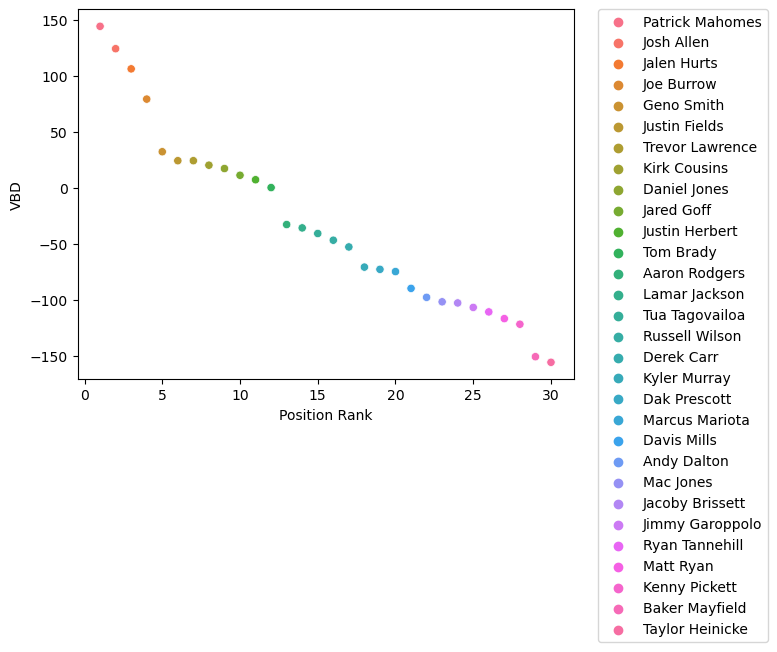

In [25]:
sns.scatterplot(data=df_2022[(df_2022['Position'] == "QB") & (df_2022['Position Rank'] <= 30)], x="Position Rank", y="VBD", hue='Player')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [26]:
print(df_2022.count(), "\n")
print(df_2022.dtypes, "\n")
print(df_2022["Team"].value_counts(), "\n")
print(df_2022["Team_1"].value_counts(), "\n")
print(df_2022["Position"].value_counts(), "\n")
print(df_2022["Player"].value_counts().head())

Player                          562
Team                            562
Position                        562
Age                             562
Games Played                    562
Games Started                   417
Completions                      88
Passing Attempts                 98
Passing Yards                    88
Passing TDs                      72
Interceptions                    72
Rushing Attempts                346
Rushing Yards                   340
Rushing Yards / Attempt         339
Rushing TDs                     157
Targets                         481
Receptions                      476
Receiving Yards                 477
Yards / Reception               476
Receiving TDs                   262
Fumbles                         237
Fumbles Lost                    160
Total TDs                       355
2 Point Conversions              52
2 Point Conversions - Passes     24
Fantasy Points                  562
VBD                             562
Position Rank               

In [27]:
#export!
df_2022.to_csv('2022.csv')
df_2022.to_excel('2022.xlsx')